## Jupyter notebook for modeling and prediction.

Import libraries that I will use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')#Sentence tokenizer
import pickle
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joaquin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load the data

In [6]:

#Import data y trained.
# Open the file in binary mode
with open('train_y.pkl', 'rb') as file:
      
    # Call load method to deserialze
    train_y = pickle.load(file)
  

#Import data x trained.
with open('train_x.pkl', 'rb') as file:
      
    # Call load method to deserialze
    train_x = pickle.load(file)


#Import data y to test.
with open('y_test.pkl', 'rb') as file:
      
    # Call load method to deserialze
    y_test = pickle.load(file)
    

#Import data x to test
with open('test.pkl', 'rb') as file:
      
    # Call load method to deserialze
    test = pickle.load(file)



## Prediction with Gaussian NB

Now we have a training set, so we can train a model. Lets start with a Gaussian NB. For run GaussianNB uncomment the following cells. 

In [8]:
from sklearn.naive_bayes import GaussianNB

#Initialize GaussianNB classifier
model = GaussianNB()
#Fit the model on the train dataset
model = model.fit(train_x, train_y)
#Make predictions on the test dataset
pred = model.predict(test)

Lets see the accuracy of the model.

In [9]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, pred)*100, "%")

Accuracy: 53.196147110332745 %


We can see that its not much different as take random choices. Maby with a gridsearch we can find better hyperparameters to get a model that perform better.

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(train_x, train_y)

gs_NB.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'var_smoothing': 0.1}

In [12]:
pred = gs_NB.best_estimator_.predict(test)

In [13]:
print("Accuracy:", accuracy_score(y_test, pred)*100, "%")

Accuracy: 55.166374781085814 %


The accuracy raice a 2%, but still low. Let's try with other model.

## Predict with Neural Network

We make a DNN with a first layer of 1024 neurons and activation 'relu'. We set a dropuot of 30% and a batch normalization. In total there are 3 layers. 

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
input_shape = [len(train_x[0])]

In [16]:

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),    
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [18]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test = np.array(test)
y_test = np.array(y_test)

Try without earlystop

In [19]:
from tensorflow.keras import layers, callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [32]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_x, train_y,
    validation_data = (test,y_test),
    batch_size=32,
    epochs=2000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.6608
Best Validation Accuracy: 0.5906


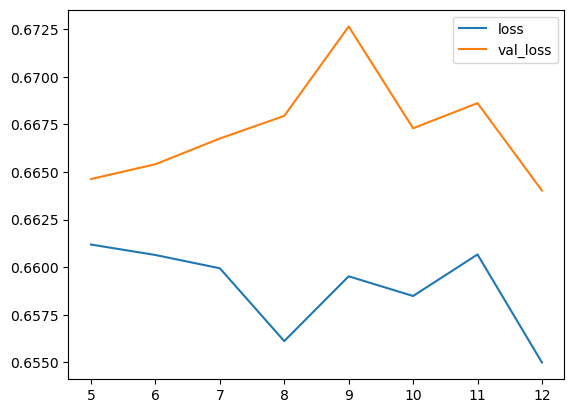

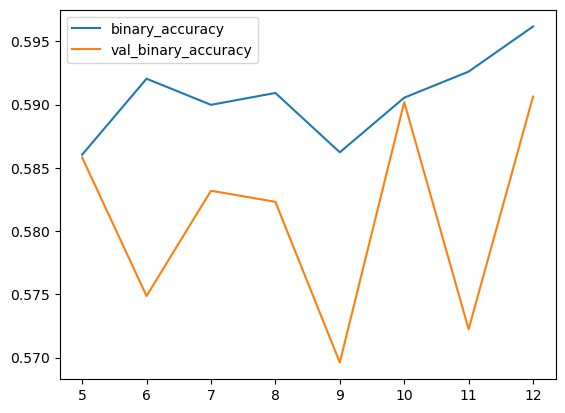

In [34]:


history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))



In [45]:
testing =[]
for i,twitt in enumerate(df_test.text):
    pattern_words = [lemm.lemmatize(word.lower()) for word in twitt]
    # create bag of words array,if word match found in current pattern then put 1 otherwise 0.[row * colm(263)]
    for w in bag_of_words:
        bag.append(1) if w in pattern_words else bag.append(0)
    testing.append(bag)
testing = np.array(testing)
   